<a href="https://colab.research.google.com/github/Orth33/music-genre-classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa tensorflow keras scikit-learn seaborn

## **4. Importing Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

## **5. Dataset Loading and Verification**

In [4]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [7]:
base_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data"
print(os.listdir(base_path))

['features_3_sec.csv', 'features_30_sec.csv', 'images_original', 'genres_original']


# **🔹 PART A: TABULAR FEATURE-BASED CLASSIFICATION**

**6. Loading Audio Features**





In [8]:
df = pd.read_csv(f"{base_path}/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


**7. Data Cleaning and Preprocessing**

In [9]:
df = df.drop(columns=['filename', 'length'], errors='ignore')

In [10]:
# Separating Features and Target Variable
X = df.drop('label', axis=1)
y = df['label']

In [11]:
# Encoding Genre Labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [12]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**8. Train–Test Split**

In [13]:
# Splitting the Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

**9. Model Training (Random Forest)**

In [14]:
# Choosing the Model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

**10. Model Evaluation (Tabular Approach)**

In [15]:
# Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


Accuracy: 0.8708708708708709
              precision    recall  f1-score   support

       blues       0.87      0.86      0.87       200
   classical       0.90      0.95      0.93       199
     country       0.80      0.83      0.82       199
       disco       0.85      0.84      0.85       200
      hiphop       0.92      0.90      0.91       200
        jazz       0.85      0.90      0.87       200
       metal       0.87      0.97      0.92       200
         pop       0.95      0.81      0.88       200
      reggae       0.82      0.88      0.85       200
        rock       0.89      0.76      0.82       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



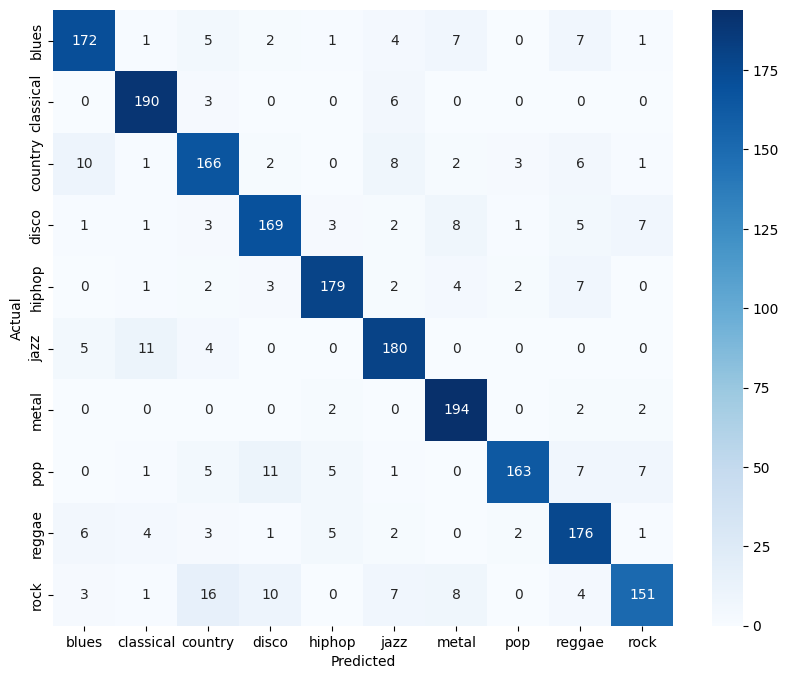

In [16]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
    cmap='Blues'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **🔹 PART B: IMAGE-BASED CLASSIFICATION (CNN)**

**11. Loading Spectrogram Images**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    f"{base_path}/images_original",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    f"{base_path}/images_original",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


**12. Transfer Learning Model**

In [18]:
# Using MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [19]:
# Model Architecture
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**13. Model Training (CNN)**

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

**14. CNN Evaluation**

In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)

**14.1 Training vs Validation Analysis**

The training history reveals a large performance gap between training and validation accuracy. Although the model converges rapidly on the training set, validation performance stagnates, indicating overfitting. This suggests that the model learns dataset-specific patterns rather than genre-invariant acoustic features.

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

# Improving overfitted model

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.15,
    width_shift_range=0.05,
    height_shift_range=0.05
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [22]:
train_gen = train_datagen.flow_from_directory(
    f"{base_path}/images_original",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    f"{base_path}/images_original",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [23]:
from tensorflow.keras.layers import Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [24]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.1151 - loss: 2.4465 - val_accuracy: 0.2261 - val_loss: 2.1475
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.2016 - loss: 2.2250 - val_accuracy: 0.3116 - val_loss: 2.0048
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2739 - loss: 2.0300 - val_accuracy: 0.3166 - val_loss: 1.9119
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2599 - loss: 2.0102 - val_accuracy: 0.3970 - val_loss: 1.8039
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3264 - loss: 1.8689 - val_accuracy: 0.3769 - val_loss: 1.7623
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3620 - loss: 1.7748 - val_accuracy: 0.3869 - val_loss: 1.6931
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3982 - loss: 1.7519 - val_accuracy: 0.4322 - val_loss: 1.6634
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3853 - loss: 1.7085 - val_accuracy: 0.4271 - val_loss:

In [28]:
train_loss, train_acc = model.evaluate(train_gen)
print("train Accuracy:", train_acc)

val_loss, val_acc = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6457 - loss: 1.0585
train Accuracy: 0.6537500023841858
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6106 - loss: 1.1369
Validation Accuracy: 0.5276381969451904


In [29]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [30]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.2532 - loss: 2.3892 - val_accuracy: 0.5226 - val_loss: 1.3280
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.3537 - loss: 1.8662 - val_accuracy: 0.5075 - val_loss: 1.3302
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.4540 - loss: 1.6381 - val_accuracy: 0.5025 - val_loss: 1.3319
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.4389 - loss: 1.6038 - val_accuracy: 0.5025 - val_loss: 1.3359
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.4456 - loss: 1.6156 - val_accuracy: 0.5075 - val_loss: 1.3405
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4935 - loss: 1.5187 - val_accuracy: 0.5176 - val_loss: 1.3483
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.5084 - loss: 1.4497 - val_accuracy: 0.5176 - val_loss: 1.3544
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.5478 - loss: 1.3353 - val_accuracy: 0.5075 - val_loss:

In [ ]:
train_loss, train_acc = model.evaluate(train_gen)
print("train Accuracy:", train_acc)

val_loss, val_acc = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)

In [ ]:
for layer in base_model.layers[-25:]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop]
)